<font color="orange">Multilevel Monte Carlo simulation for VIX options in the rough
Bergomi model</font>

Convention is different. The parameter $\eta$ in the paper must be 
replaced with $\eta \sqrt{2H}$

Let $\Delta = 30$ days. The VIX is defined as 

$$
    \text{VIX}_T = \sqrt{\frac1\Delta \int_{T}^{T+\Delta} \xi_T^u \, du}
$$

where, for all $u \geq T$,

$$
    \xi_T^u = \xi_0^u 
    \exp\left\{ \eta Y_T^u - \eta^2(u^{2H} - (u-T)^{2H})\right\}
$$

and

$$
    Y_T^u = \sqrt{2H} \int_0^T (u-s)^{H-1/2} \, dW_s
$$

We need to compute the covariance matrix of the vector 
$(Y_T^{u_i})_{0 \leq i \leq n}$ where $u_i = T + i \Delta/n$ for $i = 0, 1, \ldots, n$.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [86]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import matplotlib as mpl
import numpy as np
import seaborn as sns
from tqdm import tqdm
from utils import linear_regression

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
COLORS = ["blue", "green", "red", "orange"]
SEED = 1234

For $n \in \mathbb{N}^*$ timesteps, 
consider the uniform grid $u_i = T + i \Delta/n$ for $i = 0, 1, \ldots, n$.

We are interested in the right-point rectangle scheme

$$
    \text{VIX}_T^{2,\mathcal{R}_n}
    = \frac{1}{n} \sum_{i=1}^{n} \xi_T^{u_i}
$$

and the trapezoidal scheme

$$
    \text{VIX}_T^{2,\mathcal{T}_n}
    = \frac{1}{2n} \sum_{i=1}^{n} 
    \left(\xi_T^{u_{i-1}} + \xi_T^{u_i}\right)
$$

Observe that $\{\log \xi_{T}^{u_i}\}_{0 \leq i \leq n}$
forms an $(n+1)$-dimensional Gaussian vector with mean vector 
$\mu = \{\mu_i\}_{0 \leq i \leq n}$ and covariance matrix $C = \{C_{i,j}\}_{0 \leq i,j \leq n}$
defined as

$$
    \mu_i = \log \xi_0^{u_i} - \frac{\eta^2}{2} (u_i^{2H} - (u_i-T)^{2H})
$$

and 

$$
    C_{i,j} = 2 H \int_0^T (u_i-s)^{H-1/2} (u_j-s)^{H-1/2} \, ds
$$

The covariance matrix term $C_{i,j}$ can be computed using the Gaussian 
hypergeometric function.

A Monte Carlo estimator for the price of a VIX option with payoff $\varphi$ is

$$
    \mathbb{E}[\varphi(\text{VIX}_T^{2})] 
    \approx \frac{1}{M} \sum_{m=1}^{M} 
    \varphi \left(\frac{1}{n} \sum_{i=1}^{n} \exp\{X_T^{u_i,m}\}\right)
$$

where $X_T^u = \log \xi_T^u$. 

A natural control variate is the lognormal random variable
$\exp\left\{\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i} \right\}$. Observe that
$\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i}$ is normal with mean and standard deviation

$$
    \bar{\mu}_n = \frac{1}{n} \sum_{i=1}^{n} \mu_i,
    \qquad
    \bar{\sigma}_n = \sqrt{\frac{1}{n^2} \sum_{i,j=1}^{n} C_{i,j}}
$$




In [ ]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.3**2,
    "rho": -0.7,
    "H": 0.4,
}
params["eta"] = 0.4 * np.sqrt(2.0 * params["H"])

rbergomi = RoughBergomi(**params)

# $L^2$ error for the strong error

In [ ]:
T = 3.0 / 12.0
n_mc = 1 * 10**5
n_disc_ref = 2000

In [ ]:
# Simulate xi_{T}^{u_i}, shape is (n_disc+1, n_mc)
xi = rbergomi.simulate_vix(T=T, n_mc=n_mc, n_disc=n_disc_ref, seed=SEED, return_xi=True)

In [ ]:
vix2_right_ref = np.mean(np.exp(xi[1:, :]), axis=0)
vix2_trap_ref = 0.5 * np.mean(np.exp(xi[:-1, :]) + np.exp(xi[1:, :]), axis=0)

In [ ]:
tab_n_disc = [25, 40, 50, 80, 100, 125, 200, 250]
vix2_right = np.zeros((len(tab_n_disc), n_mc))
vix2_trap = np.zeros_like(vix2_right)

for i in range(len(tab_n_disc)):
    idx = np.arange(start=0, stop=n_disc_ref, step=n_disc_ref // tab_n_disc[i])
    vix2_right[i, :] = np.mean(np.exp(xi[1:, :][idx, :]), axis=0)
    vix2_trap[i, :] = 0.5 * np.mean(
        np.exp(xi[:-1, :][idx, :]) + np.exp(xi[1:, :][idx, :]), axis=0
    )

In [ ]:
strong_error_right = np.mean((vix2_right_ref - vix2_right) ** 2, axis=1) ** 0.5
strong_error_trap = np.mean((vix2_trap_ref - vix2_trap) ** 2, axis=1) ** 0.5

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(strong_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    np.log(rbergomi.limit_strong_error_vix_right(n=tab_n_disc, T=T)),
    ".",
    color=COLORS[0],
    label="asympt",
)
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Strong Error (right rule)")
ax[0].legend()
ax[1].plot(
    np.log(tab_n_disc),
    np.log(strong_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 6,
    "--",
    color=COLORS[1],
)
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Strong Error (trapezoidal rule)")
plt.show()

# Weak error

In [ ]:
call_atm_right_ref = np.maximum(
    vix2_right_ref**0.5 - np.mean(vix2_right_ref**0.5), 0.0
).mean()
call_atm_trap_ref = np.maximum(
    vix2_trap_ref**0.5 - np.mean(vix2_trap_ref**0.5), 0.0
).mean()

In [ ]:
call_atm_right = np.zeros(len(tab_n_disc))
call_atm_trap = np.zeros_like(call_atm_right)

for i in range(len(tab_n_disc)):
    call_atm_right[i] = np.maximum(
        vix2_right[i, :] ** 0.5 - np.mean(vix2_right[i, :] ** 0.5), 0.0
    ).mean()
    call_atm_trap[i] = np.maximum(
        vix2_trap[i, :] ** 0.5 - np.mean(vix2_trap[i, :] ** 0.5), 0.0
    ).mean()

In [ ]:
weak_error_right = np.abs(call_atm_right_ref - call_atm_right)
weak_error_trap = np.abs(call_atm_trap_ref - call_atm_trap)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(weak_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    -np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[0],
    label="slope -1",
)
ax[0].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[0],
    label="slope -2",
)
ax[0].legend()
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Weak Error (right rule)")
ax[1].plot(
    np.log(tab_n_disc),
    np.log(weak_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[1],
    label="slope -(1+H)",
)
ax[1].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[1],
    label="slope -2",
)
ax[1].legend()
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Weak Error (trapezoidal rule)")
plt.show()

# Multilevel Monte Carlo

We price an ATM VIX call option.

In [3]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 0.3,
}

rbergomi = RoughBergomi(**params)

In [15]:
T = 0.5
delta = rbergomi.delta_vix
n_mse = 10**3

In [63]:
n_disc_ref = 500
n_mc_ref = 5 * 10**5

In [64]:
vix_atm_call, vix_fut = rbergomi.price_vix(
    T=T,
    n_mc=n_mc_ref,
    n_disc=n_disc_ref,
    seed=SEED,
    rule="trap",
    control_variate=True,
    return_opt="both",
)

In [68]:
print(vix_atm_call)
print(vix_fut)

[0.00853792]
0.23402281155797855


In [34]:
n0 = 1
L = 3
n_L = n0 * 2**L

tab_x = np.linspace(T, T + delta, n_L + 1)
print(tab_x)

[0.5        0.51041667 0.52083333 0.53125    0.54166667 0.55208333
 0.5625     0.57291667 0.58333333]


In [36]:
for level in range(L + 1):
    print("Level", level)
    print("n_l=n0 * 2**level =", n0 * 2**level)
    print(tab_x[:: 2 ** (L - level)])

Level 0
n_l=n0 * 2**level = 1
[0.5        0.58333333]
Level 1
n_l=n0 * 2**level = 2
[0.5        0.54166667 0.58333333]
Level 2
n_l=n0 * 2**level = 4
[0.5        0.52083333 0.54166667 0.5625     0.58333333]
Level 3
n_l=n0 * 2**level = 8
[0.5        0.51041667 0.52083333 0.53125    0.54166667 0.55208333
 0.5625     0.57291667 0.58333333]


In [70]:
n_eps = 5
tab_eps = np.linspace(3 * 10 ** (-2), 10 * 10 ** (-2), n_eps)

mse_right_mc = np.zeros(n_eps)
cost_right_mc = np.zeros(n_eps)
mse_trap_mc = np.zeros(n_eps)
cost_trap_mc = np.zeros(n_eps)

for i in range(n_eps):
    mse_right_mc[i], cost_right_mc[i] = rbergomi.compute_mse_atm_price(
        T=T,
        n_mse=n_mse,
        true_price=vix_atm_call[0],
        true_fut=float(vix_fut),
        eps=tab_eps[i],
        opt="mc",
        rule="right",
        seed=SEED,
    )
    mse_trap_mc[i], cost_trap_mc[i] = rbergomi.compute_mse_atm_price(
        T=T,
        n_mse=n_mse,
        true_price=vix_atm_call[0],
        true_fut=float(vix_fut),
        eps=tab_eps[i],
        opt="mc",
        rule="trap",
        seed=SEED,
    )

n_mc_eps: 1112
n_disc_eps: 34


100%|██████████| 1000/1000 [00:02<00:00, 373.12it/s]


n_mc_eps: 1112
n_disc_eps: 34


100%|██████████| 1000/1000 [00:02<00:00, 388.10it/s]


n_mc_eps: 444
n_disc_eps: 22


100%|██████████| 1000/1000 [00:01<00:00, 959.26it/s]


n_mc_eps: 444
n_disc_eps: 22


100%|██████████| 1000/1000 [00:01<00:00, 982.70it/s]


n_mc_eps: 237
n_disc_eps: 16


100%|██████████| 1000/1000 [00:00<00:00, 1841.71it/s]


n_mc_eps: 237
n_disc_eps: 16


100%|██████████| 1000/1000 [00:00<00:00, 1714.54it/s]


n_mc_eps: 147
n_disc_eps: 13


100%|██████████| 1000/1000 [00:00<00:00, 2588.65it/s]


n_mc_eps: 147
n_disc_eps: 13


100%|██████████| 1000/1000 [00:00<00:00, 2548.44it/s]


n_mc_eps: 100
n_disc_eps: 10


100%|██████████| 1000/1000 [00:00<00:00, 3287.99it/s]


n_mc_eps: 100
n_disc_eps: 10


100%|██████████| 1000/1000 [00:00<00:00, 2902.45it/s]


In [76]:
n_disc_mlmc_0 = 6
n_eps = 5
# tab_eps = np.linspace(3 * 10 ** (-4), 5 * 10 ** (-4), n_eps)[::-1]
tab_eps = np.linspace(4 * 10 ** (-4), 10 * 10 ** (-4), n_eps)[::-1]

mse_right_mlmc = np.zeros(n_eps)
cost_right_mlmc = np.zeros(n_eps)
mse_trap_mlmc = np.zeros(n_eps)
cost_trap_mlmc = np.zeros(n_eps)

for i in range(n_eps):
    mse_right_mlmc[i], cost_right_mlmc[i] = rbergomi.compute_mse_atm_price(
        T=T,
        n_mse=n_mse,
        true_price=vix_atm_call[0],
        true_fut=float(vix_fut),
        eps=tab_eps[i],
        opt="mlmc",
        rule="right",
        seed=SEED,
        n_disc_mlmc_0=n_disc_mlmc_0,
    )
    mse_trap_mlmc[i], cost_trap_mlmc[i] = rbergomi.compute_mse_atm_price(
        T=T,
        n_mse=n_mse,
        true_price=vix_atm_call[0],
        true_fut=float(vix_fut),
        eps=tab_eps[i],
        opt="mlmc",
        rule="trap",
        seed=SEED,
        n_disc_mlmc_0=n_disc_mlmc_0,
    )

n_mc_eps: [192  48  12]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 846.35it/s]


n_mc_eps: [192  44  10]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 864.05it/s]


n_mc_eps: [265  66  16]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 858.96it/s]


n_mc_eps: [265  61  14]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 814.64it/s]


n_mc_eps: [390  97  24]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 809.37it/s]


n_mc_eps: [390  90  21]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 797.66it/s]


n_mc_eps: [842 210  52  13]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 326.61it/s]


n_mc_eps: [842 196  45  10]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 315.88it/s]


n_mc_eps: [1592  398   99   24]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 289.08it/s]


n_mc_eps: [1592  371   86   20]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 285.93it/s]


In [77]:
mse_right_mlmc

array([9.94881906e-07, 7.61809020e-07, 5.53284303e-07, 3.59843984e-07,
       2.52562789e-07])

In [78]:
mse_trap_mlmc

array([9.56795927e-07, 7.05531090e-07, 4.75110714e-07, 2.59400870e-07,
       1.46328551e-07])

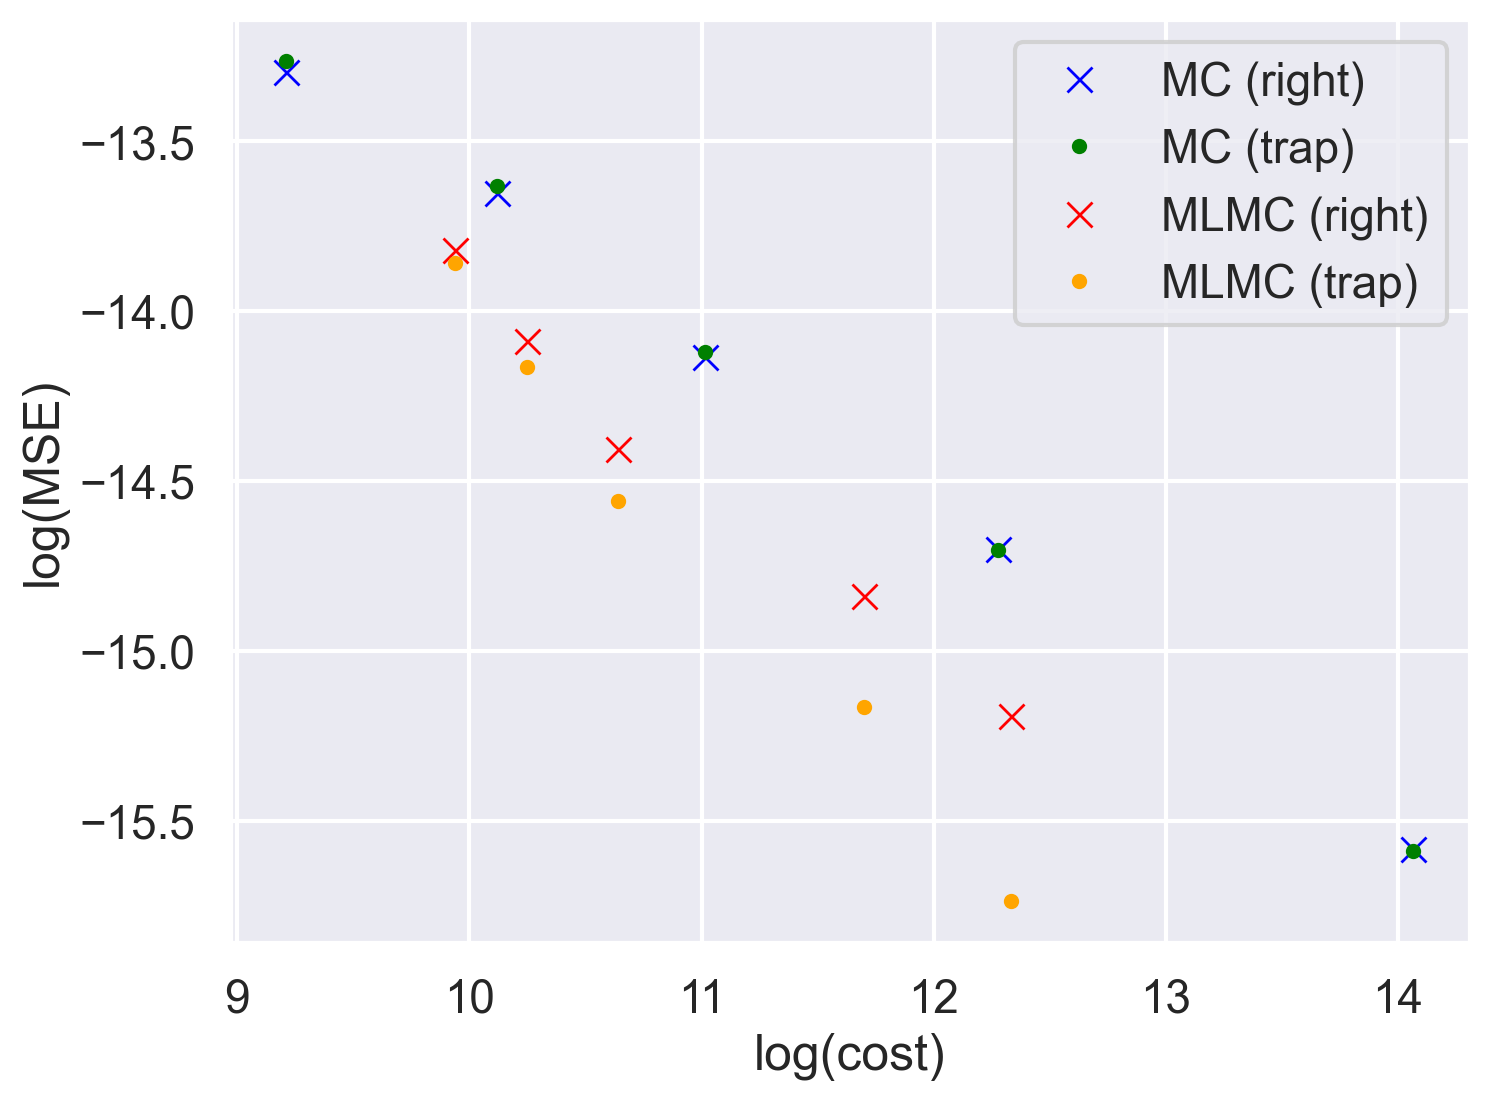

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(
    np.log(cost_right_mc),
    np.log(mse_right_mc),
    "x",
    color=COLORS[0],
    label="MC (right)",
)
ax.plot(
    np.log(cost_right_mc),
    np.log(mse_trap_mc),
    ".",
    color=COLORS[1],
    label="MC (trap)",
)
ax.plot(
    np.log(cost_right_mlmc),
    np.log(mse_right_mlmc),
    "x",
    color=COLORS[2],
    label="MLMC (right)",
)
ax.plot(
    np.log(cost_right_mlmc),
    np.log(mse_trap_mlmc),
    ".",
    color=COLORS[3],
    label="MLMC (trap)",
)
ax.set_xlabel("log(cost)")
ax.set_ylabel("log(MSE)")
ax.legend()
plt.show()

In [87]:
print(f"Linear regression for {COLORS[i]}:")
alpha, beta = linear_regression(
    np.log(cost_right_mc), np.log(mse_right_mc)
)  # MC (right)
print(f"  MC (right): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(np.log(cost_right_mc), np.log(mse_trap_mc))  # MC (trap)
print(f"  MC (trap): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(
    np.log(cost_right_mlmc), np.log(mse_right_mlmc)
)  # MLMC (right)
print(f"  MLMC (right): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(
    np.log(cost_right_mlmc), np.log(mse_trap_mlmc)
)  # MLMC (trap)
print(f"  MLMC (trap): alpha = {alpha:.3f}, beta = {beta:.3f}")


Linear regression for orange:
  MC (right): alpha = -8.891, beta = -0.475
  MC (trap): alpha = -8.787, beta = -0.483
  MLMC (right): alpha = -8.504, beta = -0.544
  MLMC (trap): alpha = -6.487, beta = -0.748


# Appendix: control variate

In [88]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.3**2,
    "rho": -0.7,
    "H": 0.3,
    "eta": 0.8,
}

rbergomi = RoughBergomi(**params)

In [89]:
T = 0.5
n_mc = 3 * 10**5
n_disc = 200
rule = "right"

vix, vix_cv = rbergomi.simulate_vix(
    T=T, n_mc=n_mc, n_disc=n_disc, seed=SEED, control_variate=True, rule=rule
)

In [ ]:
np.maximum(vix - vix.mean(), 0.0).mean()

In [ ]:
(
    np.maximum(vix - vix.mean(), 0.0).mean()
    - np.maximum(vix_cv - vix_cv.mean(), 0.0).mean()
    + rbergomi.price_vix_control_variate(T=T, K=vix_cv.mean(), n_disc=n_disc, rule=rule)
)

In [ ]:
k = np.linspace(-0.1, 0.1, 5)

In [ ]:
rbergomi.price_vix(k=k, T=T, n_mc=n_mc, n_disc=n_disc, rule=rule, control_variate=False)

In [ ]:
rbergomi.price_vix(k=k, T=T, n_mc=n_mc, n_disc=n_disc, rule=rule, control_variate=True)

In [ ]:
# TODO: clean control_vatiate option in methods.